In [212]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Add this import at the top
import copy

# Reinforcement Learning Trading Bot


## Import Data for TESLA ticker

In [213]:
tesla = yf.Ticker("TSLA")

tesla_data = tesla.history(period='5y')

df = pd.DataFrame(tesla_data)

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-12-11 00:00:00-05:00,23.458668,23.812668,23.406000,23.513332,103467000,0.0,0.0
2019-12-12 00:00:00-05:00,23.661333,24.182667,23.548668,23.978666,116458500,0.0,0.0
2019-12-13 00:00:00-05:00,24.070000,24.347334,23.642668,23.892668,98563500,0.0,0.0
2019-12-16 00:00:00-05:00,24.170000,25.573999,24.166668,25.433332,272613000,0.0,0.0
2019-12-17 00:00:00-05:00,25.266001,25.700001,25.059999,25.266001,127452000,0.0,0.0


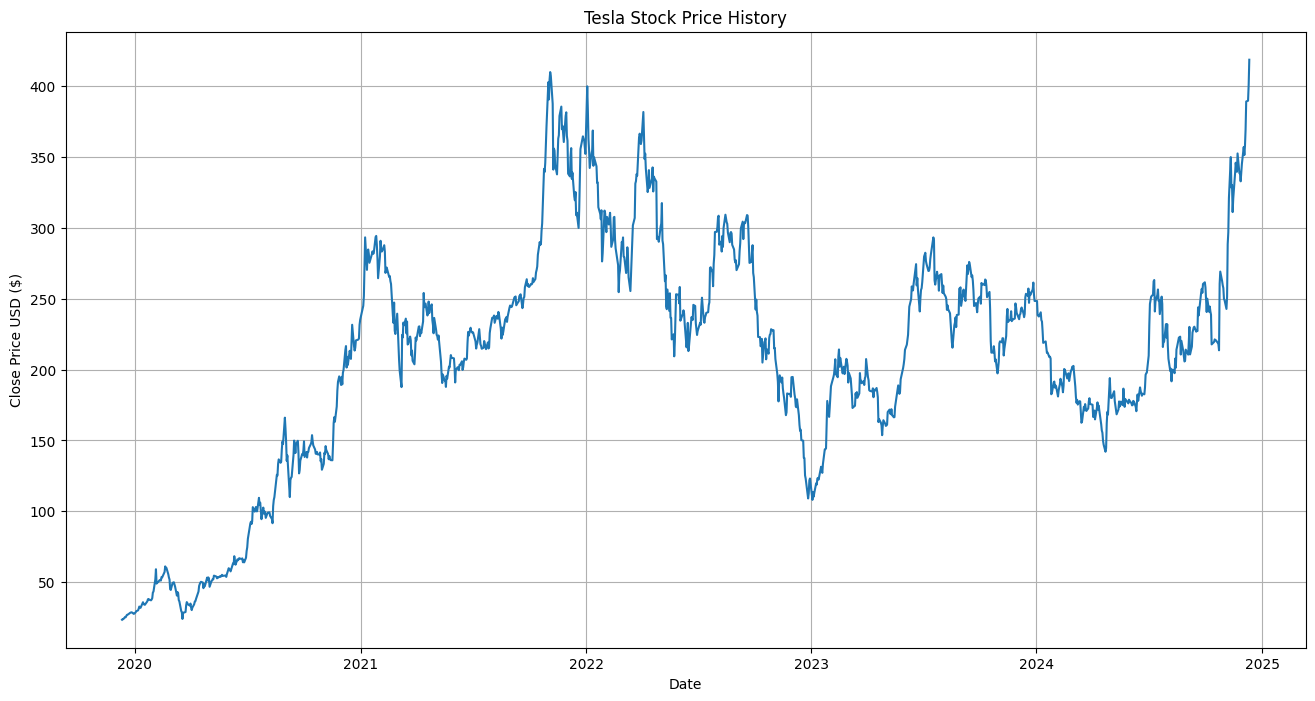

In [214]:
plt.figure(figsize=(16,8))
plt.title('Tesla Stock Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot( df.Close)
plt.grid(True)
plt.show()

## Add some features to the data
- Price Change
- Moving Average
- Volatility
- RSI
- Volume features


In [215]:

def rolling_mean(df, window=20):
    df['rolling_mean'] = df['Close'].rolling(window=window, min_periods=1).mean()
    return df

def pct_change(df):
    df['pct_change'] = df['Close'].pct_change()
    df.bfill(inplace=True)
    return df


def volatility(df, window=20):

    returns = df['Close'].pct_change()
    returns.bfill(inplace=True)

    df['volatility'] = returns.rolling(window=window, min_periods=1).std()
    df['volatility'] = df['volatility'].bfill()
    return df

def process_data(df):
    df = rolling_mean(df)
    df = volatility(df)
    df = pct_change(df)
    return df

df = process_data(df)

df.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_mean,volatility,pct_change
Date,,,,,,,,,,
2019-12-11 00:00:00-05:00,23.458668,23.812668,23.406000,23.513332,103467000,0.0,0.0,23.513332,0.000000,0.019790
2019-12-12 00:00:00-05:00,23.661333,24.182667,23.548668,23.978666,116458500,0.0,0.0,23.745999,0.000000,0.019790
2019-12-13 00:00:00-05:00,24.070000,24.347334,23.642668,23.892668,98563500,0.0,0.0,23.794889,0.013497,-0.003586
2019-12-16 00:00:00-05:00,24.170000,25.573999,24.166668,25.433332,272613000,0.0,0.0,24.204500,0.028462,0.064483
2019-12-17 00:00:00-05:00,25.266001,25.700001,25.059999,25.266001,127452000,0.0,0.0,24.416800,0.028435,-0.006579


# Basic RL QLearning setup

In [216]:
import numpy as np
import pandas as pd
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [217]:
class StockTradingEnv(gym.Env):
    def __init__(self, df, initial_balance=100000):
        super(StockTradingEnv, self).__init__()
        
        self.df = df
        initial_price = df.iloc[0]['Close']

        self.initial_position = int(initial_balance / (2*initial_price))
        self.initial_balance = initial_balance - (self.initial_position * initial_price)
        
        # Create a more balanced action space:
        # Actions structured as: [position_change, position_size]
        # position_change: -1 (sell), 0 (hold), 1 (buy)
        # position_size: 0.0 to 1.0 in steps of 0.25
        self.action_space = spaces.MultiDiscrete([3, 4])  # [3 actions, 4 size levels]
        
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(6,), dtype=np.float32)
        
        self.reset()
    
    def reset(self):
        self.current_step = 0
        self.position = self.initial_position  # No position
        self.balance = self.initial_balance  # Initial balance
        self.done = False
        self.shares_held = 0
        return self._get_observation()
    
    def _get_observation(self):
        # Implement your feature engineering here
        obs = np.array([
            self.position,
            self.df.iloc[self.current_step]['Close'],
            self.df.iloc[self.current_step]['Volume'],
            self.df.iloc[self.current_step]['rolling_mean'],
            self.df.iloc[self.current_step]['volatility'],
            self.df.iloc[self.current_step]['pct_change'],
            # Add your technical indicators here
        ])
        return obs
        
    def step(self, action):
        # Store initial values
        initial_portfolio_value = self.balance + (self.shares_held * self.df.iloc[self.current_step]['Close'])
        current_price = self.df.iloc[self.current_step]['Close']
        
        # Calculate max_shares at the beginning
        max_shares = int(self.balance / current_price) if current_price > 0 else 0
        
        position_change, size_level = action
        position_size = size_level * 0.25
        
        # Get market indicators
        market_trend = 0
        if self.current_step > 20:
            ma20 = self.df['Close'].iloc[self.current_step-20:self.current_step].mean()
            market_trend = (current_price - ma20) / ma20
        
        # Execute trade
        transaction_cost = 0.001
        old_shares_held = self.shares_held
        
        if position_change == 1:  # Buy
            shares_to_buy = int(max_shares * position_size)
            cost = shares_to_buy * current_price * (1 + transaction_cost)
            if cost <= self.balance:
                self.balance -= cost
                self.shares_held += shares_to_buy
                
        elif position_change == -1:  # Sell
            shares_to_sell = int(self.shares_held * position_size)
            self.balance += shares_to_sell * current_price * (1 - transaction_cost)
            self.shares_held -= shares_to_sell
        
        # Move to next timestep
        self.current_step += 1
        
        # Calculate reward components
        final_portfolio_value = self.balance + (self.shares_held * current_price)
        
        # 1. Portfolio return component
        portfolio_return = (final_portfolio_value - initial_portfolio_value) / initial_portfolio_value if initial_portfolio_value > 0 else 0
        
        # 2. Market alignment reward
        alignment_reward = 0
        if max_shares > 0:  # Prevent division by zero
            if market_trend > 0.02:  # Strong uptrend
                alignment_reward = self.shares_held / max_shares  # Reward for holding in uptrend
            elif market_trend < -0.02:  # Strong downtrend
                alignment_reward = (max_shares - self.shares_held) / max_shares  # Reward for not holding in downtrend
        
        # 3. Profit taking reward
        profit_taking_reward = 0
        if position_change == -1 and portfolio_return > 0:
            profit_taking_reward = portfolio_return * 0.5  # Bonus for taking profits
        
        # 4. Risk management reward
        risk_reward = 0
        portfolio_concentration = (self.shares_held * current_price) / final_portfolio_value if final_portfolio_value > 0 else 0
        if portfolio_concentration > 0.7:  # Penalize over-concentration
            risk_reward = -0.001 * (portfolio_concentration - 0.7)
        
        # 5. Trading activity reward
        trading_reward = 0
        if position_change != 0 and abs(old_shares_held - self.shares_held) > 0:
            trading_reward = 0.0005  # Small reward for taking action
        
        # Combine all reward components
        reward = (
            portfolio_return * 1.0 +          # Base portfolio return
            alignment_reward * 0.3 +          # Market alignment
            profit_taking_reward * 0.4 +      # Profit taking
            risk_reward * 0.2 +              # Risk management
            trading_reward                    # Trading activity
        )
        
        # Check if episode is done
        self.done = self.current_step >= len(self.df) - 1
        
        # Add some information to the info dict
        info = {
            'portfolio_value': final_portfolio_value,
            'shares_held': self.shares_held,
            'balance': self.balance,
            'return': portfolio_return,
            'market_trend': market_trend,
            'action_taken': position_change,
            'position_size': position_size
        }
        
        return self._get_observation(), reward, self.done, info

In [218]:
# DQN Network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [219]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

Episode: 0, Total Reward: 33943.71, Epsilon: 0.01, portfolio value: 68.50
Episode: 10, Total Reward: 26961.78, Epsilon: 0.01, portfolio value: 93.08
Episode: 20, Total Reward: -9576.25, Epsilon: 0.01, portfolio value: 241.09
Episode: 30, Total Reward: 23468.17, Epsilon: 0.01, portfolio value: 80.73
Episode: 40, Total Reward: -4978.87, Epsilon: 0.01, portfolio value: 34.86
Episode: 50, Total Reward: -2963.39, Epsilon: 0.01, portfolio value: 263.22
Best reward achieved: -inf


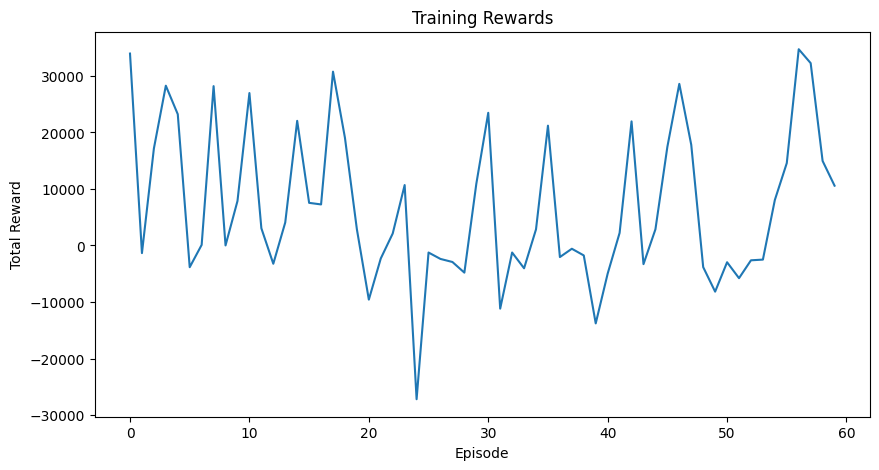

In [220]:
import random
from collections import deque
import torch.nn.functional as F

class DQNAgent:
    def __init__(self, state_size, action_size, env, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.state_size = state_size
        self.action_size = action_size
        self.env = env
        self.device = device
        self.memory = ReplayBuffer(100000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 64
        self.learning_rate = 0.001

        # Get the dimensions of the action space
        self.n_positions = env.action_space.nvec[0]  # Number of position changes (3: buy/hold/sell)
        self.n_sizes = env.action_space.nvec[1]      # Number of size levels (4: 0.25, 0.5, 0.75, 1.0)

        self.policy_net = DQN(state_size, action_size).to(device)
        self.target_net = DQN(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    def act(self, state):
        if random.random() <= self.epsilon:
            # Generate random action as tuple
            position = np.random.randint(0, self.n_positions)
            size = np.random.randint(0, self.n_sizes)
            return (position, size)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            action_idx = q_values.max(1)[1].item()
            
            # Convert flat action index back to tuple
            position = action_idx // self.n_sizes
            size = action_idx % self.n_sizes
            return (position, size)

    def _flatten_action(self, action):
        # Convert action tuple to flat index for neural network
        position, size = action
        return position * self.n_sizes + size

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))

        state_batch = torch.FloatTensor(batch[0]).to(self.device)
        # Convert action tuples to flat indices
        action_batch = torch.LongTensor([self._flatten_action(a) for a in batch[1]]).to(self.device)
        reward_batch = torch.FloatTensor(batch[2]).to(self.device)
        next_state_batch = torch.FloatTensor(batch[3]).to(self.device)
        done_batch = torch.FloatTensor(batch[4]).to(self.device)

        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        expected_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))

        loss = F.smooth_l1_loss(current_q_values.squeeze(), expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training loop
def train_agent_with_best(env, agent, episodes=60):
    rewards_history = []
    best_reward = float('-inf')
    best_portfolio_value = float('-inf')
    best_state_dict = None
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)
            
            agent.memory.push(state, action, reward, next_state, done)
            agent.train()
            
            state = next_state
            total_reward += reward
            
        rewards_history.append(total_reward)

        # Save the best model
        if info['balance'] > best_portfolio_value:
            best_portfolio_value = info['balance']
            best_state_dict = copy.deepcopy(agent.policy_net.state_dict())
        
        if episode % 10 == 0:
            print(f"Episode: {episode}, Total Reward: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}, portfolio value: {info['balance']:.2f}")
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    # Load the best model
    agent.policy_net.load_state_dict(best_state_dict)
    agent.target_net.load_state_dict(best_state_dict)
    
    return rewards_history, best_reward



# Train and get the best model
env = StockTradingEnv(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.nvec.prod()
agent = DQNAgent(state_size, action_size, env)

rewards, best_reward = train_agent_with_best(env, agent)
print(f"Best reward achieved: {best_reward:.2f}")

# Plot training results
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title('Training Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.show()

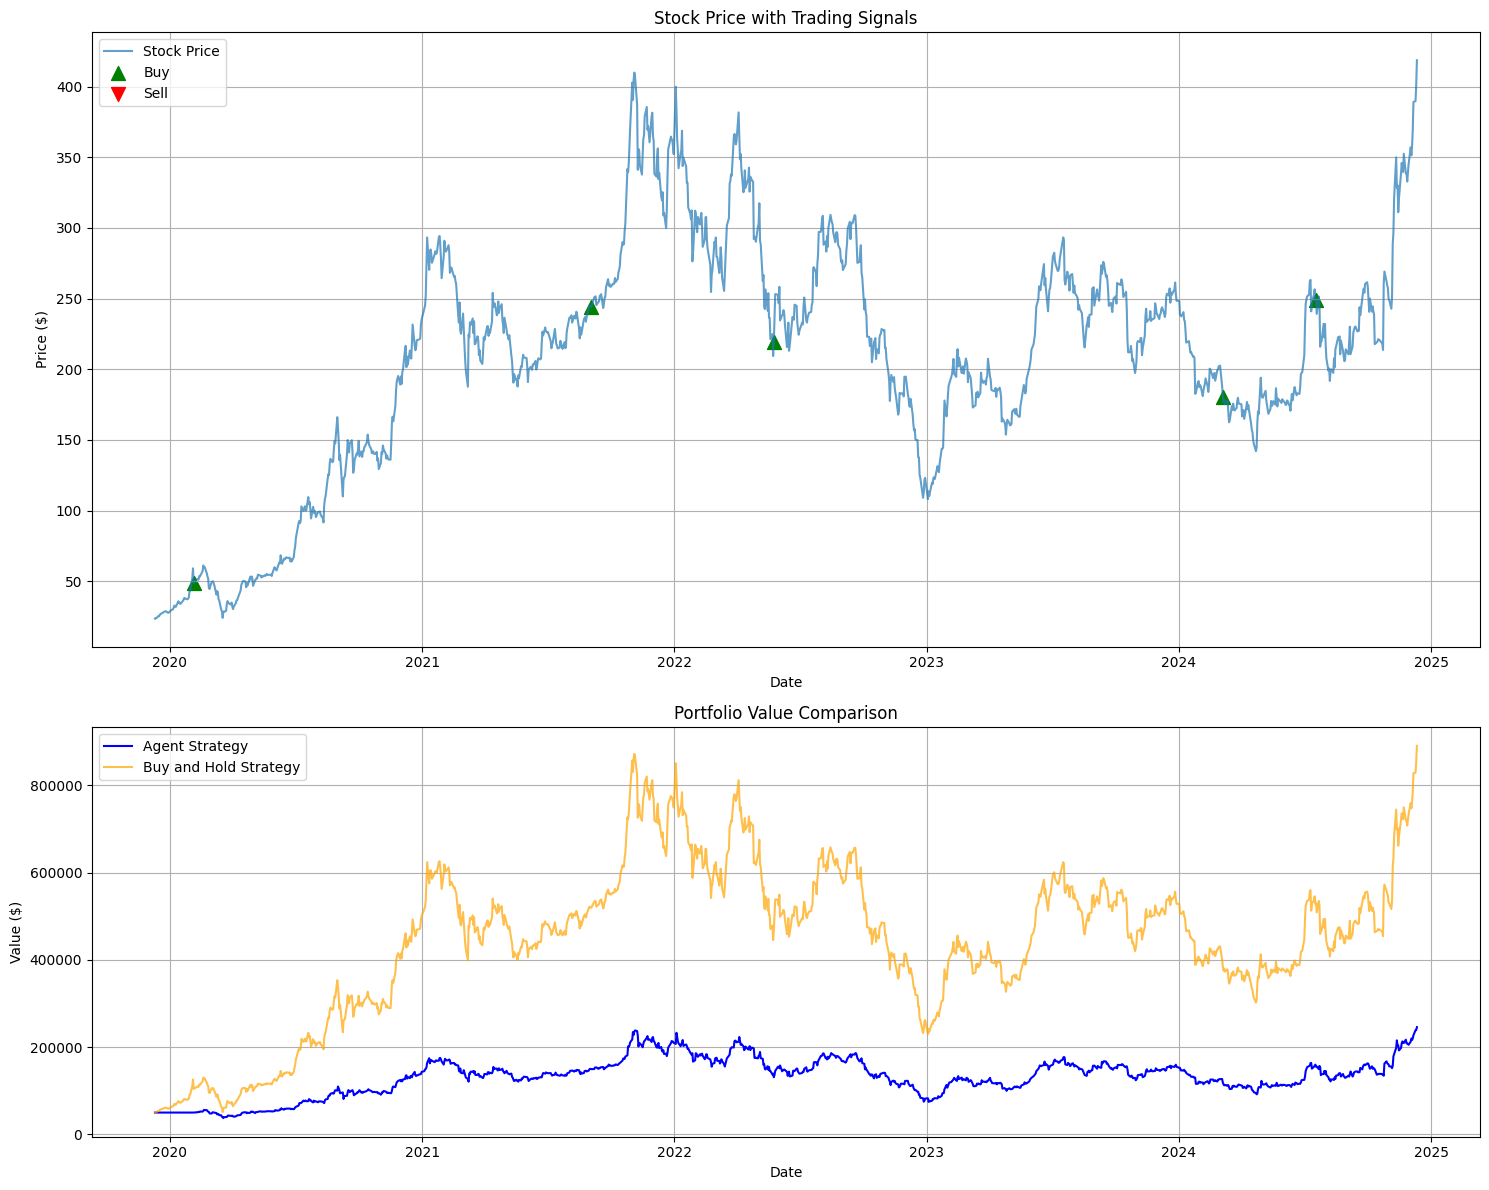


=== Performance Comparison ===
Initial Investment: $50,010.66

Agent Strategy:
Final Value: $245,813.45
Total Return: 391.52%
Number of Trades: 5

Buy and Hold Strategy:
Final Value: $890,545.90
Total Return: 1680.71%

Risk Metrics:
Agent Sharpe Ratio: 0.87
Buy-Hold Sharpe Ratio: 1.20
Agent Maximum Drawdown: 68.78%
Buy-Hold Maximum Drawdown: 73.63%


In [221]:
def visualize_trades_with_benchmark(env, agent, df):
    # Run agent strategy
    state = env.reset()
    done = False
    
    buy_dates = []
    sell_dates = []
    portfolio_values = [env.balance]
    initial_balance = env.balance
    dates = df.index
    current_step = 0
    
    while not done:
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        
        if action[0] == 1:  # Buy
            buy_dates.append(dates[current_step])
        elif action[0] == -1:  # Sell
            sell_dates.append(dates[current_step])
            
        portfolio_values.append(info['portfolio_value'])
        state = next_state
        current_step += 1
    
    # Calculate buy-and-hold strategy
    initial_stock_price = df['Close'].iloc[0]
    num_shares_buyhold = initial_balance / initial_stock_price
    buyhold_values = df['Close'] * num_shares_buyhold
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), height_ratios=[1.5, 1])
    
    # Plot 1: Stock price with buy/sell points
    ax1.plot(dates, df['Close'], label='Stock Price', alpha=0.7)
    ax1.scatter(buy_dates, df.loc[buy_dates]['Close'], 
                color='green', marker='^', label='Buy', s=100)
    ax1.scatter(sell_dates, df.loc[sell_dates]['Close'], 
                color='red', marker='v', label='Sell', s=100)
    ax1.set_title('Stock Price with Trading Signals')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Portfolio Value Comparison
    ax2.plot(dates[:len(portfolio_values)], portfolio_values, 
             label='Agent Strategy', color='blue')
    ax2.plot(dates, buyhold_values, 
             label='Buy and Hold Strategy', color='orange', alpha=0.7)
    ax2.set_title('Portfolio Value Comparison')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value ($)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print statistics
    agent_final_value = portfolio_values[-1]
    buyhold_final_value = buyhold_values.iloc[-1]
    
    agent_return = ((agent_final_value - initial_balance) / initial_balance) * 100
    buyhold_return = ((buyhold_final_value - initial_balance) / initial_balance) * 100
    
    print("\n=== Performance Comparison ===")
    print(f"Initial Investment: ${initial_balance:,.2f}")
    print("\nAgent Strategy:")
    print(f"Final Value: ${agent_final_value:,.2f}")
    print(f"Total Return: {agent_return:.2f}%")
    print(f"Number of Trades: {len(buy_dates) + len(sell_dates)}")
    
    print("\nBuy and Hold Strategy:")
    print(f"Final Value: ${buyhold_final_value:,.2f}")
    print(f"Total Return: {buyhold_return:.2f}%")
    
    # Calculate additional metrics
    agent_values = np.array(portfolio_values)
    agent_returns = np.diff(agent_values) / agent_values[:-1]
    buyhold_returns = buyhold_values.pct_change().dropna()
    
    agent_sharpe = np.sqrt(252) * np.mean(agent_returns) / np.std(agent_returns)
    buyhold_sharpe = np.sqrt(252) * np.mean(buyhold_returns) / np.std(buyhold_returns)
    
    # Maximum drawdown calculation
    agent_peak = np.maximum.accumulate(agent_values)
    agent_drawdown = (agent_peak - agent_values) / agent_peak
    agent_max_drawdown = np.max(agent_drawdown) * 100
    
    buyhold_peak = np.maximum.accumulate(buyhold_values)
    buyhold_drawdown = (buyhold_peak - buyhold_values) / buyhold_peak
    buyhold_max_drawdown = np.max(buyhold_drawdown) * 100
    
    print("\nRisk Metrics:")
    print(f"Agent Sharpe Ratio: {agent_sharpe:.2f}")
    print(f"Buy-Hold Sharpe Ratio: {buyhold_sharpe:.2f}")
    print(f"Agent Maximum Drawdown: {agent_max_drawdown:.2f}%")
    print(f"Buy-Hold Maximum Drawdown: {buyhold_max_drawdown:.2f}%")

# Run the visualization with benchmark comparison
visualize_trades_with_benchmark(env, agent, df)

Mean evaluation reward: 693.99


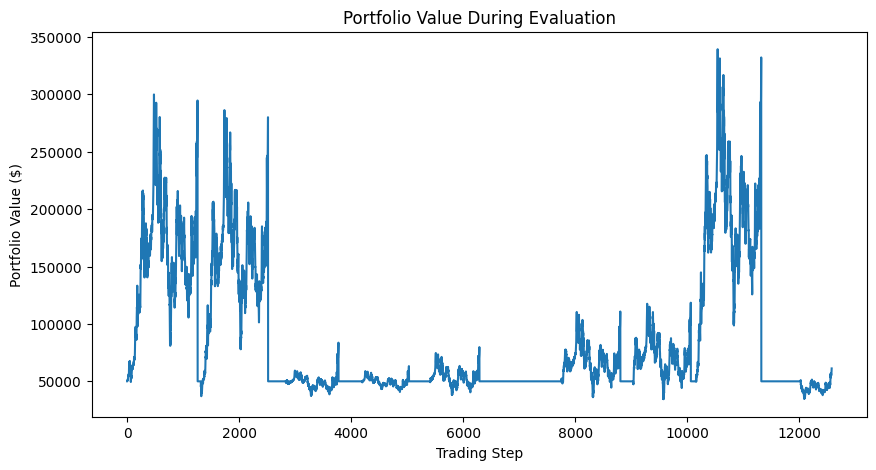

In [222]:
def evaluate_agent(env, agent, episodes=10):
    total_rewards = []
    portfolio_values = []
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            action = agent.act(state)  # During evaluation, we don't need epsilon-greedy
            next_state, reward, done, info = env.step(action)
            
            state = next_state
            episode_reward += reward
            portfolio_values.append(info['portfolio_value'])
        
        total_rewards.append(episode_reward)
        
    return np.mean(total_rewards), portfolio_values

# Evaluate the trained agent
mean_reward, portfolio_history = evaluate_agent(env, agent)
print(f"Mean evaluation reward: {mean_reward:.2f}")

# Plot portfolio value over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_history)
plt.title('Portfolio Value During Evaluation')
plt.xlabel('Trading Step')
plt.ylabel('Portfolio Value ($)')
plt.show()